This notebook contains an introduction to Reactmine and some results provided in the article.

## Table of contents:
1. [Reactmine basic functions](#basic)

    1.1 [Loading the data](#data)

    1.2 [Instantiating a Reactmine object](#obj)

    1.3 [Fitting a Reactmine object to data](#fit)

    1.4 [Few visualizations](#viz)

    1.5 [Breaking down the fit](#break)

2. [Grid search hyperparameters optimization](#grid)

3. [Lack of generalization from Sindy's inferred models](#sindy)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from crninf.algorithm import get_skeletons, Reactmine
from crninf.evaluate import predict
from crninf.utils import low_complexity_crn, print_crn, set_matplotlib_params
from toy_crns import func_crn_name # necessitates to load the notebook from the examples directory

import itertools

In [2]:
set_matplotlib_params()
np.random.seed(13)

# <a id="basic"></a> Reactmine basic functions

<a id="data"></a>
## Loading the data

In [3]:
crn_name = "chain" 
# can be "parallel", "reactant_parallel", "product_parallel", "chain", "loop", "mapk", see toy_crns.py

T, npts = 10, 101 # Time horizon and number of time points
t = np.linspace(0, T, npts)

gt_crn, K, cata, species_names, y0, ode = func_crn_name(crn_name)()
exps = odeint(ode, y0, t, atol=10 ** (-12), rtol=10 ** (-12))

`gt_crn` corresponds to the ground truth stoichiometry matrix

`K` is the kinetic parameters vector

`cata` is a vector with size the number of reactions of the ground truth CRN (same as `K`). `-1` means no catalyst
for the reaction, otherwise the value is the species index, e.g. `0` means that `A` is a catalyst of the reaction.

`ode` is the ODE system associated with the ground truth crn.

## <a id="obj"></a> Instantiating a Reactmine object

In [4]:
algo = Reactmine(y=[exps], t=[t], v=None,
                 species_names=species_names, verbose=True,
                 alpha=.05, beta=7, gamma=6, delta_max=3, delta_step=0.1)

Data must be given to Reactmine as a list, same for the time grids (typically in Fucci, time grids are not
the same across all traces so a list of them is necessary).

In accordance with the notation in the article, we therefore have:

`y`: list of time series of molecular concentrations  
`t`: list of time grids  
`v`: list of velocities time series. If None (default), estimated velocities will be computed using `(y,t)`  
`species_names`:  name for species. If None (default), will be filled with `["A", "B", "C", ...]`  
`verbose`: whether or not printing messages  
`alpha`: CV-based reaction acceptance threshold  
`beta`: number of candidates  
`gamma`: maximal size of inferred CRNs  
`delta_max`: maximum absolute fold change between species variations in a reaction  
`delta_step`: step for the delta grid $[1, 1+\delta_{step},\dots,\delta_{\max}]$, set to $0.1$ and never touched in practice.

In the Reactmine object are stored the data and velocities:

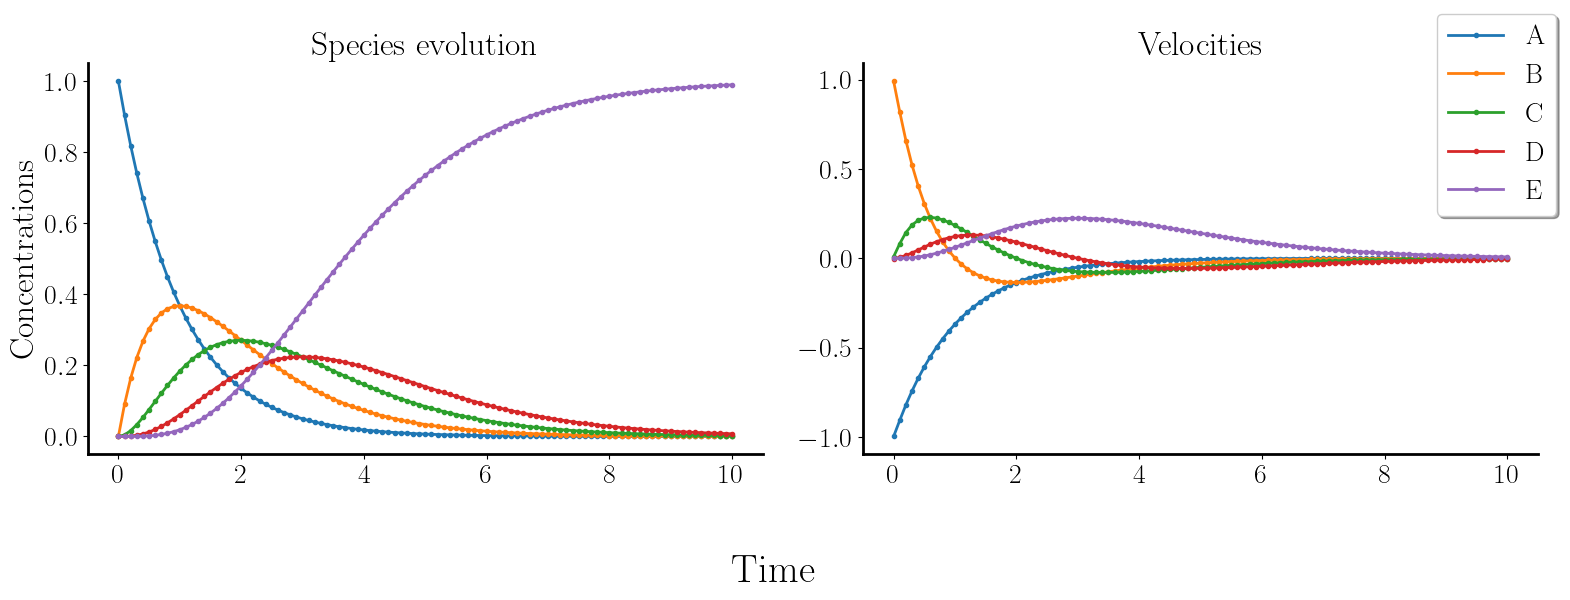

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(t, algo.y, marker='o', markersize=3)
axes[0].set_title('Species evolution')
axes[1].plot(t, algo.v, marker='o', markersize=3)
axes[1].set_title('Velocities')
fig.supxlabel("Time")
axes[0].set_ylabel("Concentrations")
fig.legend(species_names, shadow=True)
fig.tight_layout()
plt.show()

## <a id="fit"></a> Fitting a Reactmine object to data

In [6]:
tree, crnlist, error = algo.fit()

currently exploring level: 2
currently exploring level: 3
currently exploring level: 4
currently exploring level: 5
currently exploring level: 6
final globopt of all inferred CRNs


`tree` contains the research tree, it is a list of $\gamma$ lists: one per level.  
`crnlist` contains the list of inferred CRNs, sorted from best fit (lowest energy) to worse fit (highest energy)  
`energies` is the list of associated energies

In [7]:
print(f"{len(crnlist)} CRNs have been inferred")

1080 CRNs have been inferred


In [8]:
for i in range(5):
    print(f"CRN n°{i} with energy {error[i]}")
    print_crn(crnlist[i], species_names)
    print('\n')

CRN n°0 with energy 2.6900951221062218e-05
MA(0.99739) for D -> E
MA(0.99735) for C -> D
MA(0.99675) for B -> C
MA(1.00062) for A -> B
MA(0.0) for C -> E
MA(0.01046) for B -> E with catalyst E


CRN n°1 with energy 2.6961214958378864e-05
MA(0.9989) for D -> E
MA(0.99678) for C -> D
MA(0.99635) for B -> C
MA(1.00054) for A -> B
MA(0.0151) for A + E -> D
MA(0.00088) for B -> D + E


CRN n°2 with energy 2.7082731793715224e-05
MA(0.99804) for D -> E
MA(0.9968) for C -> D
MA(0.99702) for B -> C
MA(1.00058) for A -> B
MA(0.00106) for A + B -> E
MA(0.00603) for C -> D + E with catalyst D


CRN n°3 with energy 2.7088879817358073e-05
MA(0.99778) for D -> E
MA(0.99612) for C -> D
MA(0.99702) for B -> C
MA(1.0006) for A -> B
MA(0.00017) for A + B -> E
MA(0.00154) for C -> D + E


CRN n°4 with energy 2.7137079812741395e-05
MA(0.99846) for D -> E
MA(0.99768) for C -> D
MA(0.99724) for B -> C
MA(1.00064) for A -> B
MA(0.00133) for A + B -> E
MA(0.00179) for C -> D + E with catalyst E




As we can see, the first CRNs are actually the chain CRN, plus some tiny reactions. More precisely, 45 crns roughly obtain the same error. A little post processing should yield the right CRN.

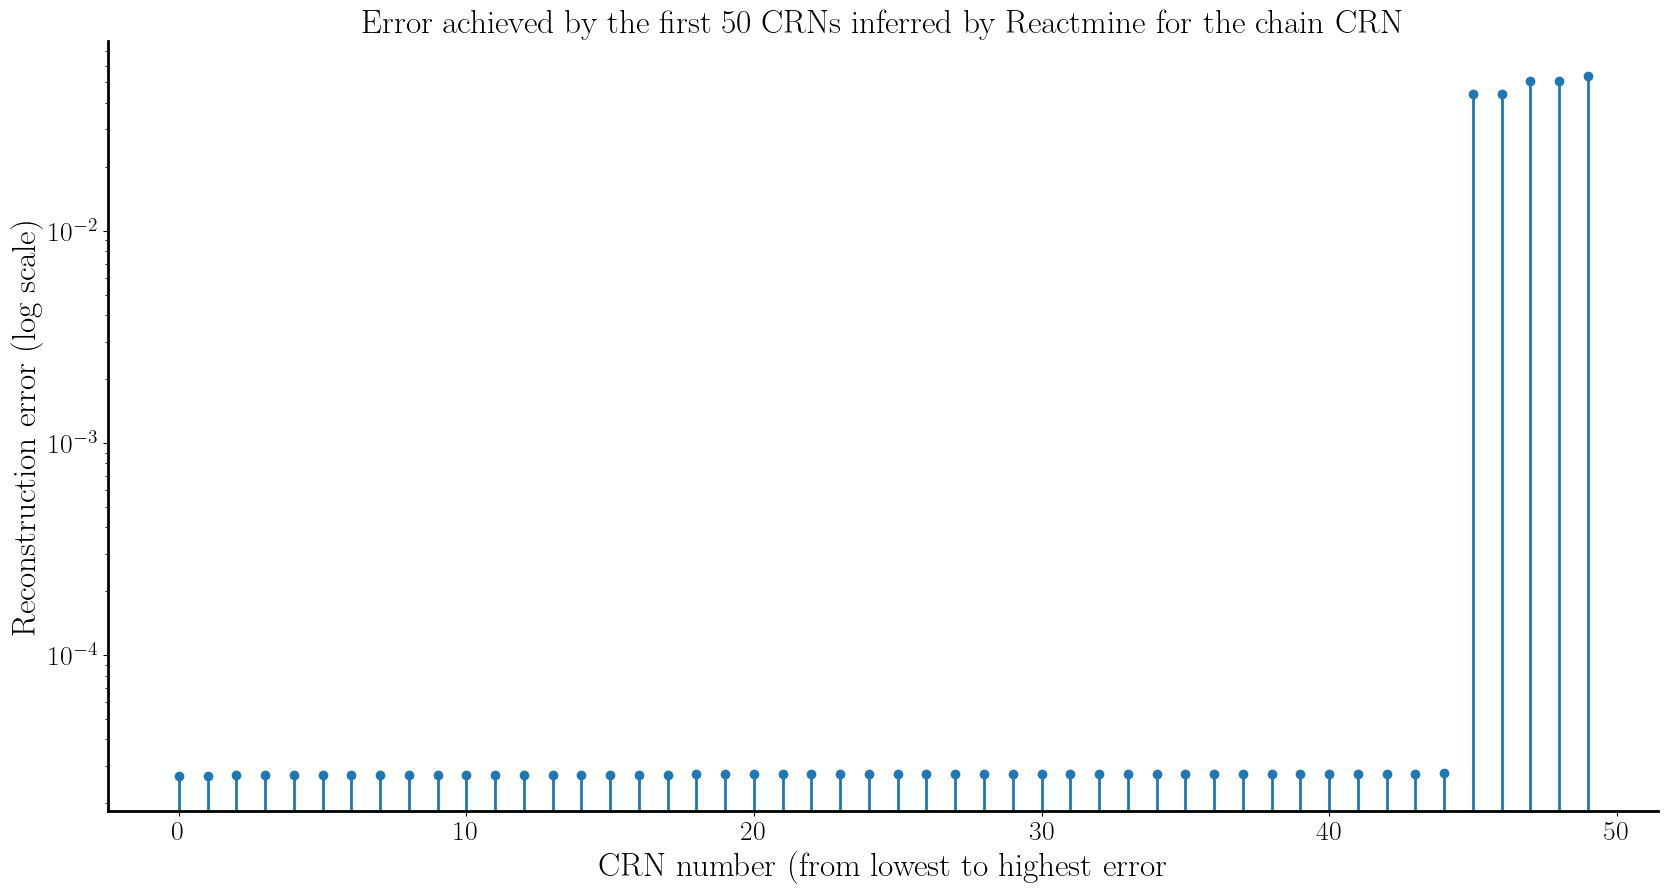

In [9]:
fig, axes = plt.subplots(1,1, figsize=(20, 10))
axes.stem(error[:50])
axes.set_yscale("log")
axes.set_title("Error achieved by the first 50 CRNs inferred by Reactmine for the chain CRN")
axes.set_xlabel("CRN number (from lowest to highest error")
axes.set_ylabel("Reconstruction error (log scale)")
plt.show()

In [10]:
bestcrn, idxbestcrn = low_complexity_crn(crnlist, error, atol=10**(-3), rtol=1.1)

Given that $E^*$ is the lowest error, this function collects all the CRNs $\mathcal{R}$ s.t.

$$\frac{E_\mathcal{R}}{E^*} < 1.1 \text{  or  } E_\mathcal{R} < {E^*} + 10^{-3}$$

and returns the one that has the smallest number of reactions, removing the reactions with kinetic parameters equal to 0 set by the final step of global optimization constrained in $\mathbb{R}_+$.

In [11]:
print_crn(bestcrn, species_names)

MA(0.99869) for D -> E
MA(0.99837) for C -> D
MA(0.99753) for B -> C
MA(1.00069) for A -> B


## <a id="viz"></a> Few visualizations

We can then check that the learned CRN indeed provide an accurate numerical simulation (even though we never
fitted any numerical simulation, only velocities)

In [12]:
ypred, vpred = predict(bestcrn, y0, t) # does not work for Michaelis Menten CRNs yet.

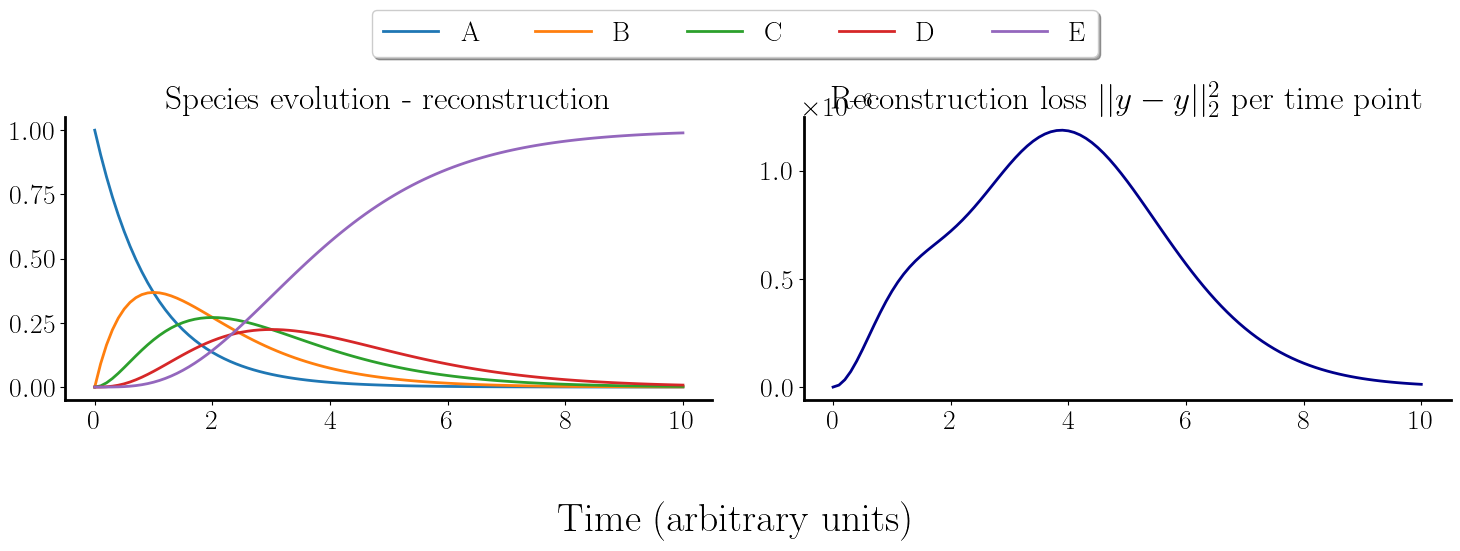

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(t, ypred)
axes[1].plot(t, np.linalg.norm(algo.y - ypred, axis=1)**2, color='darkblue')
axes[0].set_title("Species evolution - reconstruction")
axes[1].set_title('Reconstruction loss $||y-y||_2^2$ per time point')
fig.supxlabel('Time (arbitrary units)')
fig.legend(species_names, shadow=True, bbox_to_anchor=(.75, 1.1), ncol=5)
fig.tight_layout()
plt.show()

And we can also have a look at the support of a reaction, which is the set of time points at which an inferred reaction was witnessed.
This set is computed over the _normalized_ velocities $\tilde{v}$, defined from the estimated velocities $\hat{v}$ for $1 \le l \le n,~1\le i \le m$ as
$$\tilde{v}_{l, i} = \frac{\hat{v}_{l,i}}{\underset{1\le l \le n}{\max} |\hat{v}_{l,i}|}$$

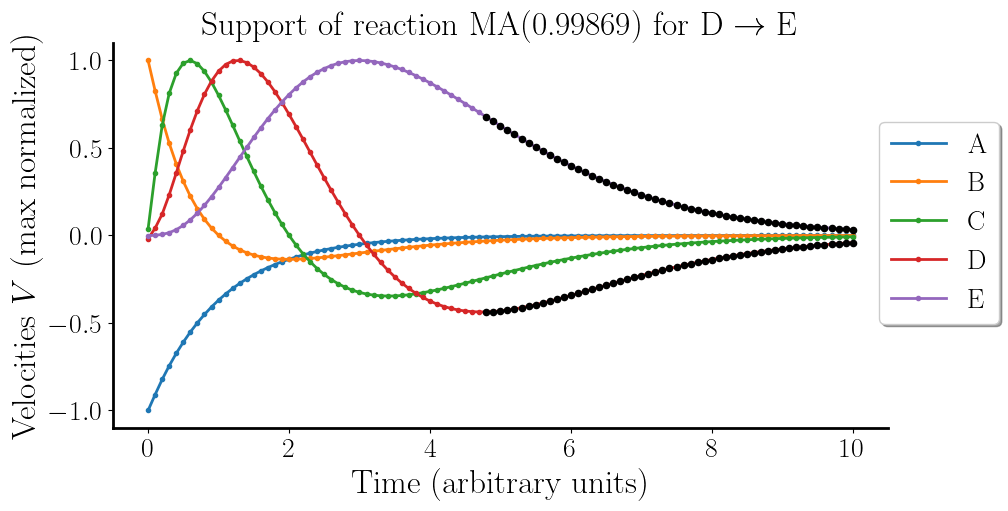

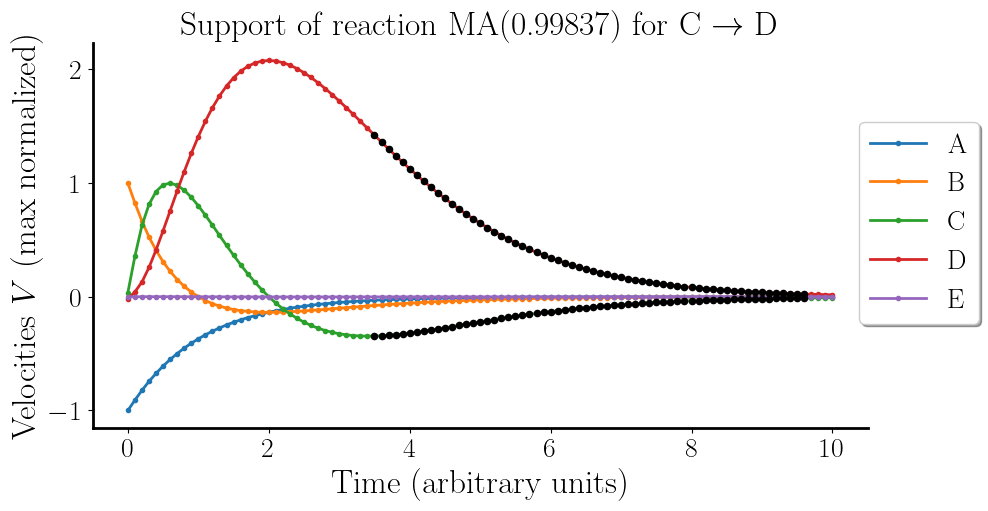

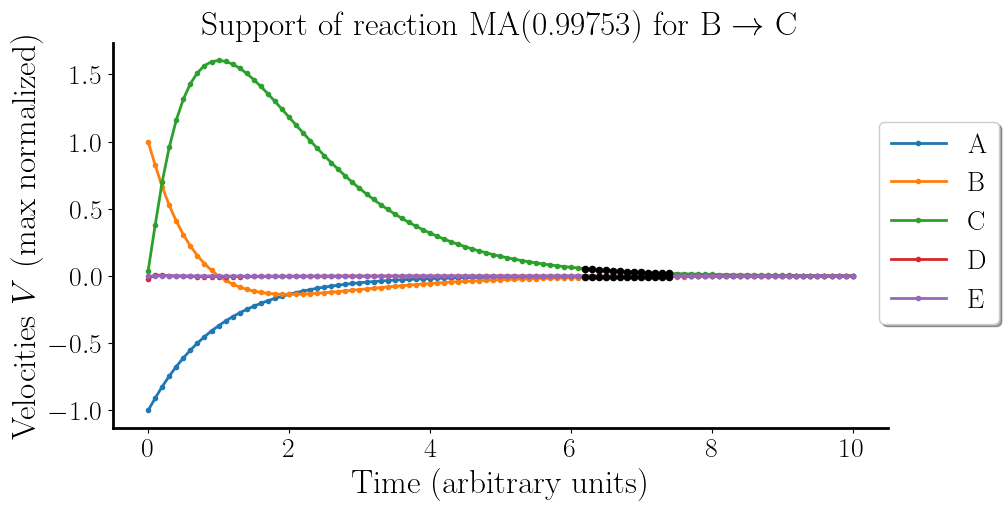

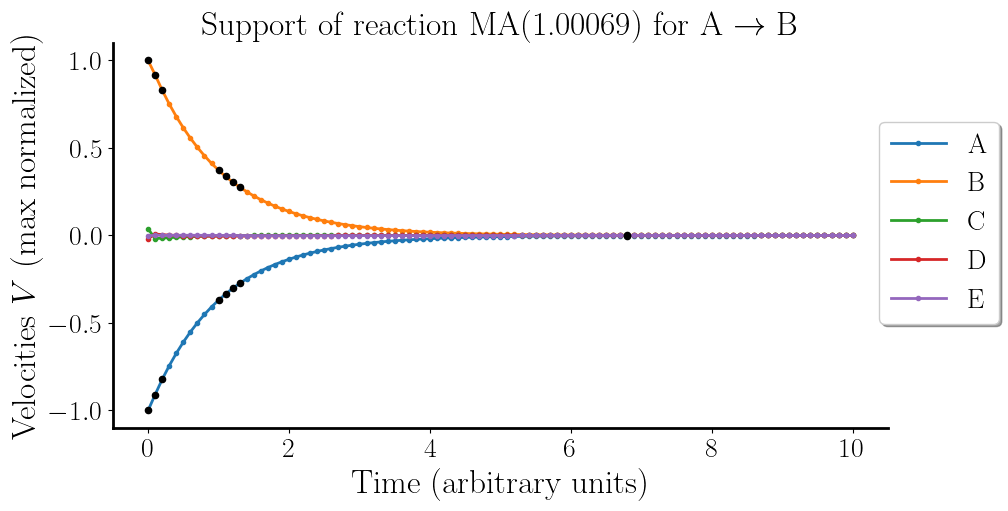

[None, None, None, None]

In [14]:
[algo.plot_support(bestcrn[f"reaction {i}"], tree) for i in range(len(bestcrn))]

## <a id="break"></a>  Breaking down the fit

Let us shortly describe the inference process for a reaction. 

### Generation of reaction skeletons

In [15]:
skeleton_matrix, support = get_skeletons(algo.vinit, algo.delta)

`skeleton_matrix` is a matrix which contains one stoichiometry vector per reaction skeleton  
`support` is a dict, with entries reaction skeletons written as tuple, e.g. `(-1, 1, 0, 0, 0)`

In [16]:
skeleton_matrix # one stoichiometry vector per reaction skeleton

array([[-1.,  0.,  0., -0., -0.],
       [-1.,  1.,  1.,  0.,  0.],
       [-1.,  0.,  1.,  0.,  0.],
       [-1.,  0.,  1.,  1.,  0.],
       [-1., -0.,  0.,  1.,  0.],
       [-1., -0.,  0.,  1.,  1.],
       [-0., -0.,  0.,  0.,  1.],
       [-0., -0., -0., -1.,  1.],
       [-1.,  1.,  0., -0., -0.],
       [-1., -0.,  0.,  0.,  1.],
       [-1., -1.,  0.,  0.,  1.],
       [-0., -1., -0.,  0.,  1.],
       [-0., -0., -1., -1.,  1.],
       [-0., -0., -1., -0.,  1.],
       [-0., -1., -1., -0.,  1.]])

 index of time points and time points for which $D\rightarrow E$ has been witnessed:

In [17]:
support[(0, 0, 0, -1, 1)], t[support[(0, 0, 0, -1, 1)]]

([72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  68,
  69,
  70,
  71,
  64,
  65,
  66,
  67,
  61,
  62,
  63,
  58,
  59,
  60,
  56,
  57,
  54,
  55,
  52,
  53,
  51,
  49,
  50,
  48],
 array([ 7.2,  7.3,  7.4,  7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,
         8.3,  8.4,  8.5,  8.6,  8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,
         9.4,  9.5,  9.6,  9.7,  9.8,  9.9, 10. ,  6.8,  6.9,  7. ,  7.1,
         6.4,  6.5,  6.6,  6.7,  6.1,  6.2,  6.3,  5.8,  5.9,  6. ,  5.6,
         5.7,  5.4,  5.5,  5.2,  5.3,  5.1,  4.9,  5. ,  4.8]))

Let us continue with this reaction as an example

In [18]:
de = skeleton_matrix[7]
suppab = support[tuple(de)]

We can associate mass action law kinetics to the reaction skeleton

In [19]:
reac = algo.get_kinetics(skeleton=de, v=algo.vinit, support=suppab, cata=-1)
print(reac)

{'cv': 0.00035320053445209214, 'kinetics': 1.0004174061212514, 'skeleton': array([-0., -0., -0., -1.,  1.]), 'cata': -1, 'effect': (<bound method Reactmine.kinetics_function of <crninf.algorithm.Reactmine object at 0x14eacc040>>, array([3])), 'supp': [72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 68, 69, 70, 71, 64, 65, 66, 67, 61, 62, 63, 58, 59, 60, 56, 57, 54, 55, 52, 53, 51, 49, 50, 48], 'km': 0}


What we obtain is a reaction, written as a `dict`, whose entries are:

`cv`: coefficient of variation. The latter can be computed over either `D` or `E`. The value reported is the lowest one  
`kinetics`: MAL parameter  
`skeleton`: stoichiometry vector which was given as input  
`cata`: catalyst. The value is `-1` is there is no catalyst, and the species index otherwise  
`effect` a tuple whose first argument is a callable which computes the effect of the inferred reaction. The second argument is the set of reactants.  
`supp`: support of the reaction which was given as input  
`km`: Km parameter for MM reaction, set to 0 for a MAL reaction

As an example, computing the catalyzed reaction $D+C\rightarrow E+C$ would have yield

In [20]:
wrongreac = algo.get_kinetics(skeleton=de, v=algo.vinit, support=suppab, cata=2) # A:0; B:1; C:2; D:3; E:4
print(f"cv={wrongreac['cv']} ; k={wrongreac['kinetics']}")

cv=1.0441566321145053 ; k=110.09684069728058


We observe a high coefficient of variation (CV), several orders of magnitude higher than the previous one, as well as high kinetics. For mass action law reactions, the effect of these reactions can be obtained
as the product of the reactants concentration.

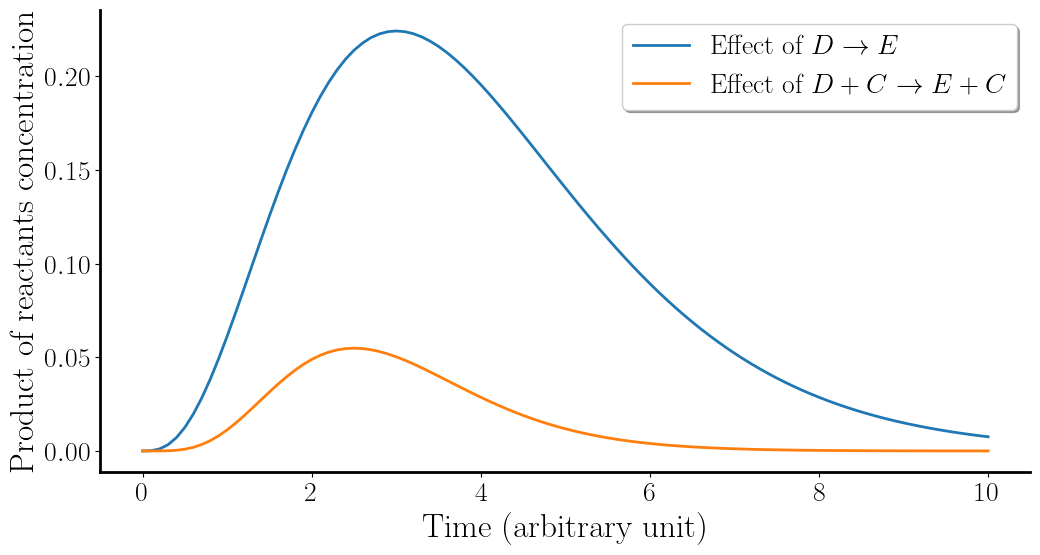

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(t, reac["effect"][0](reac["effect"][1]), label=r'Effect of $D\rightarrow E$') # last parameter of the callable is km, the michaelis menten constant, set to 0
plt.plot(t, wrongreac["effect"][0](wrongreac["effect"][1]), label=r'Effect of $D+C\rightarrow E+C$')
plt.xlabel('Time (arbitrary unit)')
plt.ylabel("Product of reactants concentration")
plt.legend(shadow=True)
plt.show()

This does not include the kinetic parameter, i.e. the effect of $D\rightarrow E$ is simply the function $y:t \mapsto y_D(t)$, and that of $D+C\rightarrow E+C$ is the product of $D$ and $C$'s concentrations.

Once a reaction is inferred, it is removed from the velocities:

In [22]:
velo_remove_de = algo.transition_update(reac, algo.vinit)
velo_remove_dcec = algo.transition_update(wrongreac, algo.vinit)

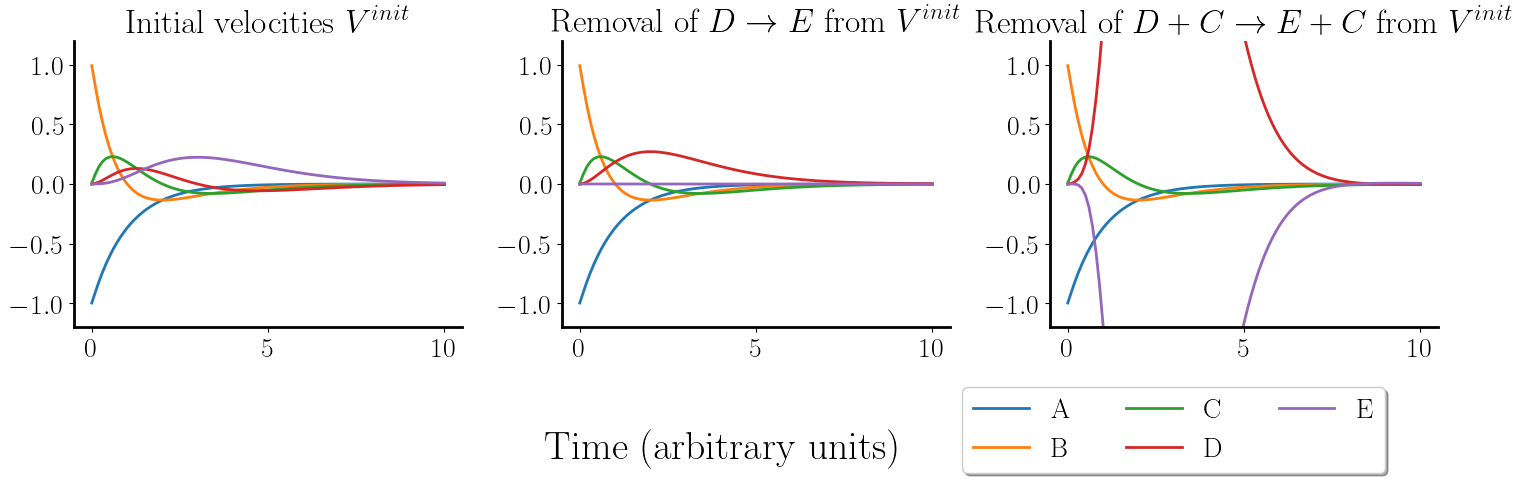

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].plot(t, algo.vinit)
axes[1].plot(t, velo_remove_de)
axes[2].plot(t, velo_remove_dcec)
axes[0].set_title(r'Initial velocities $V^{init}$')
axes[1].set_title(r'Removal of $D\rightarrow E$ from $V^{init}$')
axes[2].set_title(r'Removal of $D+C\rightarrow E+C$ from $V^{init}$')
[ax.set_ylim(-1.2, 1.2) for ax in axes]
fig.supxlabel('Time (arbitrary units)')
fig.legend(species_names, bbox_to_anchor=(.95, .2), ncol=3, shadow=True)
fig.tight_layout()
plt.show()

Finally, the global optimization step will reoptimize the kinetic parameters of an inferred CRN. This is done by comparing the observed velocities $V^{\text{init}}$ (before the effect of any reaction is removed)
and the inferred velocities. The latter are computed using $F(Y, k)$, the matrix of the reaction effects and the stoichiometry matrix $S$.

$$k = \underset{k\in \mathbb{R}^p_+}{\text{argmin}} ||V^{\text{init}} - F(Y, k)S||^2_F$$

In [24]:
opti_crn, err = algo.globopt(list(crnlist[0].values()))

# <a id="grid"></a> Grid search hyperparameters optimization

Next, we briefly show how the output CRN can be selected through a grid search over Reactmine's hyperparameters. We consider the Lokta-Volterra prey-predator model. A prey species $B$ and a predator species $A$ interact given
the following CRN:

\begin{align*}
A &\xrightarrow{0.3} \emptyset\\
B &\xrightarrow{1} 2B\\
A+B &\xrightarrow{0.01} 2A
\end{align*}

In [25]:
crn_name = "lv" 
T, npts = 50, 101
t = np.linspace(0, T, npts)

gt_crn, K, cata, species_names, y0, ode = func_crn_name(crn_name)()
exps = odeint(ode, y0, t, atol=10 ** (-12), rtol=10 ** (-12))

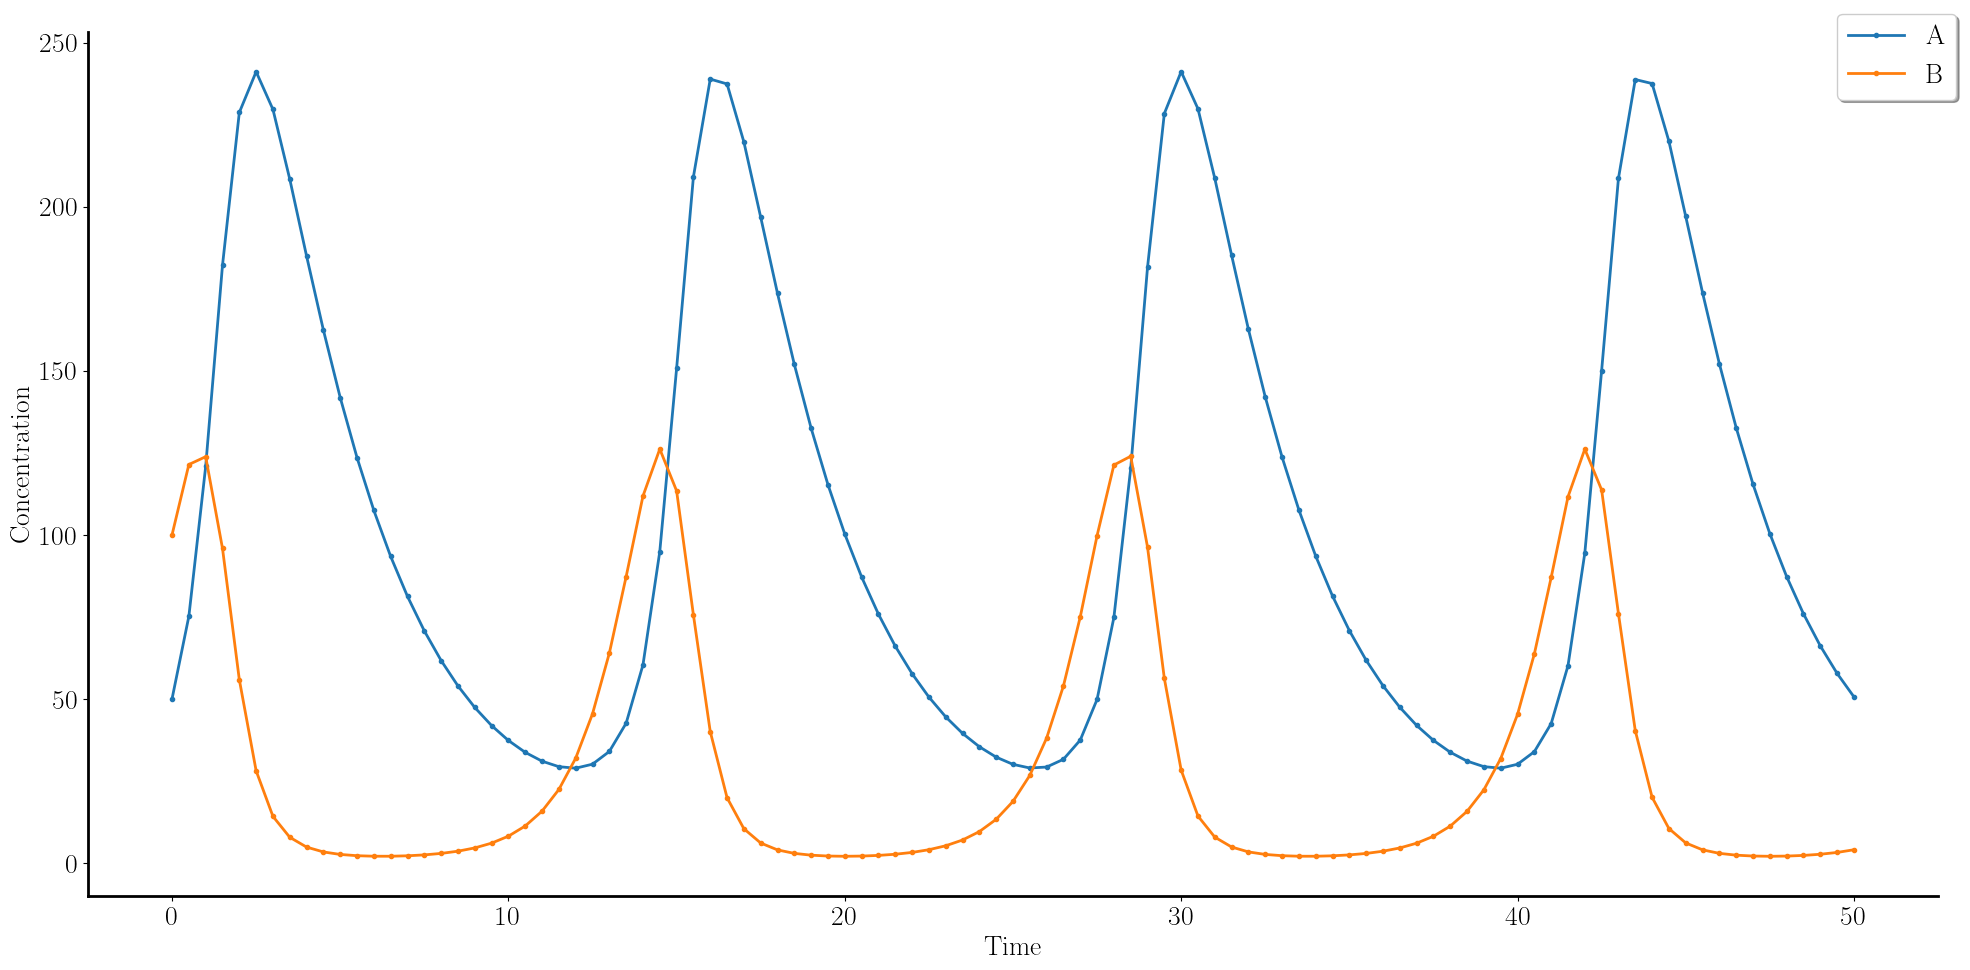

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(20, 10))
axes.plot(t, exps, marker='o', markersize=3)
axes.set_xlabel('Time',fontsize=20)
axes.set_ylabel('Concentration',fontsize=20)
fig.legend(species_names, shadow=True, fontsize=20)
fig.tight_layout()
plt.show()  

Next, we define a grid of hyperparameters values to try for Reactmine:

In [27]:
deltas = [3, 4]
alphas = [.05, .1, .15, .2, .25, .3, .5]
betas = [4, 5, 6, 7, 8]
gammas = [3, 4, 5]
params = list(itertools.product(*[alphas, betas, gammas, deltas]))

For this small example (2 variables and max crn size of 5), the loop over hyperparameters runs in roughly 1 minute on a standard laptop.

In [28]:
crnlist, errors = [], []
for i, p in enumerate(params):
    print(i) if not (i%10) else None
    alpha, beta, gamma, delta = p
    algo = Reactmine(y=[exps], t=[t], v=None,
                     species_names=species_names, verbose=False,
                     alpha=alpha, beta=beta, gamma=gamma, delta_max=delta)

    tree, crns, error = algo.fit()
    crnlist += crns
    errors += error

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


In [29]:
sort = np.argsort(errors)
errors = [errors[s] for s in sort]
crnlist = [crnlist[s] for s in sort]

In [30]:
bestcrn, idxbestcrn = low_complexity_crn(crnlist, errors)
print_crn(bestcrn, species_names)

MA(0.28498) for A -> ∅
MA(0.00949) for B -> A with catalyst A
MA(0.95395) for ∅ -> B with catalyst B
